<a href="https://colab.research.google.com/github/manojAL/Resume-1/blob/main/distilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')

# Alternative: Upload directly
from google.colab import files
print("Upload your dataset file:")
uploaded = files.upload()

# Check uploaded files
!ls -la

Mounted at /content/drive
Upload your dataset file:


Saving fraud_call (1).csv to fraud_call (1) (1).csv
total 1012
drwxr-xr-x 1 root root   4096 Feb 14 16:29  .
drwxr-xr-x 1 root root   4096 Feb 14 16:21  ..
drwxr-xr-x 4 root root   4096 Jan 16 14:24  .config
drwx------ 5 root root   4096 Feb 14 16:29  drive
-rw-r--r-- 1 root root 507317 Feb 14 16:29 'fraud_call (1) (1).csv'
-rw-r--r-- 1 root root 507317 Feb 14 16:23 'fraud_call (1).csv'
drwxr-xr-x 1 root root   4096 Jan 16 14:24  sample_data


In [ ]:
# Install CPU-optimized packages
!pip install transformers datasets imbalanced-learn scikit-learn pandas numpy matplotlib seaborn torch torchvision torchaudio --quiet
!pip install accelerate -U --quiet
!pip install torch --index-url https://download.pytorch.org/whl/cpu --quiet  # Ensure CPU version

# Verify installations
import torch
import transformers
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")  # Should be False
print(f"CPU cores available: {torch.get_num_threads()}")

PyTorch version: 2.9.0+cpu
Transformers version: 5.0.0
CUDA available: False
CPU cores available: 1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# CPU optimizations
torch.set_num_threads(4)  # Use 4 CPU threads (adjust based on your CPU)
print(f"Using {torch.get_num_threads()} CPU threads")

# Set device
device = torch.device('cpu')
print(f"Using device: {device}")

# Set random seeds
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

Using 4 CPU threads
Using device: cpu


In [ ]:
# Load your dataset
df = pd.read_csv('fraud_calls_data (1).csv', encoding='utf-8')

print("="*50)
print("ORIGINAL DATASET STRUCTURE")
print("="*50)
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())

# Fix the column names - the first column is 'fraud' (label), second column is 'text'
# Current: column0 = 'fraud', column1 = first message
# We need to rename them properly

# Method 1: Simple rename
df.columns = ['label', 'text']

print("\n" + "="*50)
print("FIXED DATASET STRUCTURE")
print("="*50)
print(f"New columns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())

# Check if any rows are misaligned
print("\n" + "="*50)
print("SAMPLE ROWS")
print("="*50)
for i in range(5):
    print(f"\nRow {i}:")
    print(f"Label: {df['label'].iloc[i]}")
    print(f"Text: {df['text'].iloc[i][:100]}...")

ORIGINAL DATASET STRUCTURE
Shape: (5924, 2)

Columns: ['fraud', 'hello, i m bank manager of SBI, ur debit card is about to expire would u want to issue new  card.']

First 5 rows:
    fraud  \
0   fraud   
1  normal   
2  normal   
3  normal   
4  normal   

  hello, i m bank manager of SBI, ur debit card is about to expire would u want to issue new  card.  
0  Todays Vodafone numbers ending with 4882 are s...                                                 
1               Please don't say like that. Hi hi hi                                                 
2                                         Thank you!                                                 
3  Oh that was a forwarded message. I thought you...                                                 
4  Got it. Seventeen pounds for seven hundred ml ...                                                 

FIXED DATASET STRUCTURE
New columns: ['label', 'text']

First 5 rows:
    label                                               te

In [ ]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Drop any rows with missing text
df = df.dropna(subset=['text'])
print(f"\nAfter dropping NA: {len(df)} rows")

# Check label values
print("\nUnique labels before cleaning:")
print(df['label'].unique())

Missing values:
label    0
text     0
dtype: int64

After dropping NA: 5924 rows

Unique labels before cleaning:
['fraud' 'normal']


In [ ]:
# Clean the label column
df['label'] = df['label'].astype(str).str.strip()

# Check what we have
print("Label values after stripping:")
print(df['label'].value_counts())

# Standardize to 'fraud' and 'normal'
df['label'] = df['label'].apply(lambda x: 'fraud' if 'fraud' in x.lower() else 'normal')

print("\nAfter standardization:")
print(df['label'].value_counts())

# Create integer labels
df['label_int'] = df['label'].map({'normal': 0, 'fraud': 1})

print("\nFinal label mapping:")
print(df[['label', 'label_int']].drop_duplicates())

Label values after stripping:
label
normal    5287
fraud      637
Name: count, dtype: int64

After standardization:
label
normal    5287
fraud      637
Name: count, dtype: int64

Final label mapping:
    label  label_int
0   fraud          1
1  normal          0


In [ ]:
# Check text column
print("Text column info:")
print(f"Number of texts: {len(df)}")
print(f"Any null texts: {df['text'].isnull().sum()}")
print(f"Text length range: {df['text'].str.len().min()} to {df['text'].str.len().max()}")

# Show sample texts
print("\nSample texts:")
for i in range(5):
    print(f"\n{i+1}. Label: {df['label'].iloc[i]}")
    print(f"   Text: {df['text'].iloc[i][:150]}...")

Text column info:
Number of texts: 5924
Any null texts: 0
Text length range: 2 to 910

Sample texts:

1. Label: fraud
   Text: Todays Vodafone numbers ending with 4882 are selected to a receive a £350 award. If your number matches call 09064019014 to receive your £350 award....

2. Label: normal
   Text: Please don't say like that. Hi hi hi...

3. Label: normal
   Text: Thank you!...

4. Label: normal
   Text: Oh that was a forwarded message. I thought you send that to me....

5. Label: normal
   Text: Got it. Seventeen pounds for seven hundred ml – hope ok....


In [ ]:
def clean_text(text):
    """Clean text data"""
    if not isinstance(text, str):
        return ""

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\']', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Apply cleaning
print("Cleaning text data...")
df['clean_text'] = df['text'].apply(clean_text)

# Show examples
print("\n" + "="*50)
print("CLEANING EXAMPLES")
print("="*50)
for i in range(3):
    print(f"\nOriginal: {df['text'].iloc[i][:100]}...")
    print(f"Cleaned:  {df['clean_text'].iloc[i][:100]}...")

# Add text length feature for analysis
df['text_length'] = df['clean_text'].str.len()

Cleaning text data...

CLEANING EXAMPLES

Original: Todays Vodafone numbers ending with 4882 are selected to a receive a £350 award. If your number matc...
Cleaned:  todays vodafone numbers ending with 4882 are selected to a receive a 350 award. if your number match...

Original: Please don't say like that. Hi hi hi...
Cleaned:  please don't say like that. hi hi hi...

Original: Thank you!...
Cleaned:  thank you!...


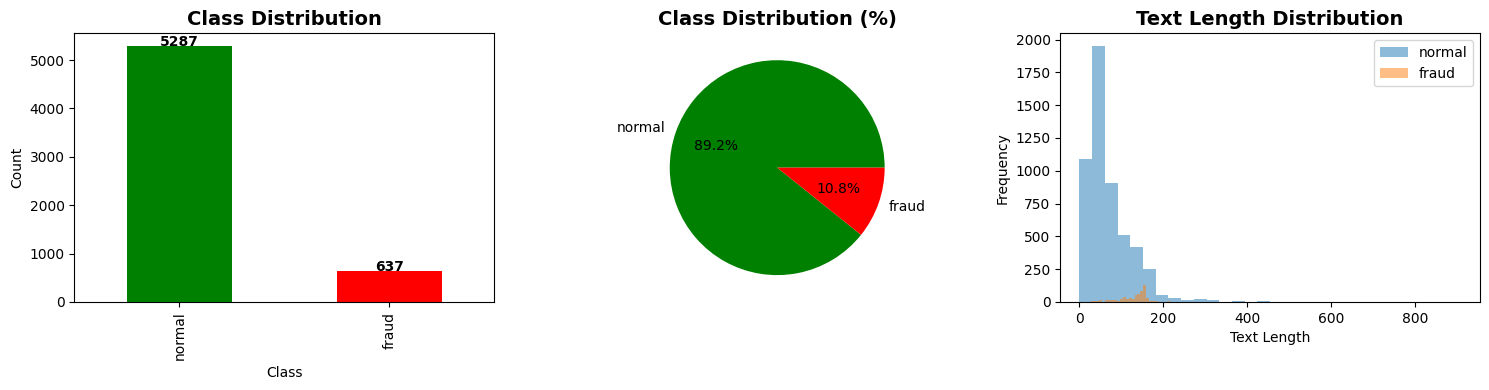


Imbalance Ratio (Normal:Fraud) = 8.30:1
Fraud samples: 637 (10.75%)
Normal samples: 5287 (89.25%)


In [ ]:
# Class distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Class counts
ax1 = axes[0]
df['label'].value_counts().plot(kind='bar', ax=ax1, color=['green', 'red'])
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
for i, v in enumerate(df['label'].value_counts().values):
    ax1.text(i, v + 5, str(v), ha='center', fontweight='bold')

# Plot 2: Pie chart
ax2 = axes[1]
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax2, colors=['green', 'red'])
ax2.set_title('Class Distribution (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

# Plot 3: Text length distribution
ax3 = axes[2]
for label in ['normal', 'fraud']:
    subset = df[df['label'] == label]
    ax3.hist(subset['text_length'], alpha=0.5, label=label, bins=30)
ax3.set_title('Text Length Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Text Length')
ax3.set_ylabel('Frequency')
ax3.legend()

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
fraud_count = len(df[df['label'] == 'fraud'])
normal_count = len(df[df['label'] == 'normal'])
imbalance_ratio = normal_count / fraud_count

print(f"\nImbalance Ratio (Normal:Fraud) = {imbalance_ratio:.2f}:1")
print(f"Fraud samples: {fraud_count} ({fraud_count/len(df)*100:.2f}%)")
print(f"Normal samples: {normal_count} ({normal_count/len(df)*100:.2f}%)")

In [ ]:
# Split data - ALWAYS FIRST before any balancing
X = df['clean_text']
y = df['label_int']

# Stratified split to maintain class distribution
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,  # 30% for temp (will be split into validation and test)
    random_state=42,
    stratify=y
)

# Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of temp = 15% of total
    random_state=42,
    stratify=y_temp
)

print("="*50)
print("DATA SPLIT RESULTS")
print("="*50)
print(f"Training set:   {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set:       {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print("\nClass distribution:")
print(f"Train - Normal: {sum(y_train==0)}, Fraud: {sum(y_train==1)}")
print(f"Val   - Normal: {sum(y_val==0)}, Fraud: {sum(y_val==1)}")
print(f"Test  - Normal: {sum(y_test==0)}, Fraud: {sum(y_test==1)}")

# Calculate class weights for handling imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"\nClass weights (for loss function): Normal={class_weights[0]:.2f}, Fraud={class_weights[1]:.2f}")

DATA SPLIT RESULTS
Training set:   4146 samples (70.0%)
Validation set: 889 samples (15.0%)
Test set:       889 samples (15.0%)

Class distribution:
Train - Normal: 3700, Fraud: 446
Val   - Normal: 793, Fraud: 96
Test  - Normal: 794, Fraud: 95

Class weights (for loss function): Normal=0.56, Fraud=4.65


In [ ]:
class FraudDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Load tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Determine optimal max length
text_lengths = [len(str(text).split()) for text in X_train]
max_len = min(128, int(np.percentile(text_lengths, 95)))  # Use 95th percentile or 128, whichever smaller
print(f"Using max sequence length: {max_len}")

# Create datasets
train_dataset = FraudDataset(X_train, y_train, tokenizer, max_len)
val_dataset = FraudDataset(X_val, y_val, tokenizer, max_len)
test_dataset = FraudDataset(X_test, y_test, tokenizer, max_len)

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Using max sequence length: 33

Train dataset size: 4146
Val dataset size: 889
Test dataset size: 889


In [ ]:
# Load model with dropout for regularization
from transformers import DistilBertConfig

# Create config with dropout parameters
config = DistilBertConfig.from_pretrained(
    model_name,
    num_labels=2,
    hidden_dropout_prob=0.3,  # Dropout for regularization
    attention_probs_dropout_prob=0.3,
    output_attentions=False,
    output_hidden_states=False
)

# Load model with config
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

# Move model to device
model.to(device)

# Define weighted loss function with updated signature
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply class weights if provided
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

print("Model initialized successfully")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model initialized successfully
Trainable parameters: 66,955,010


In [ ]:
def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate metrics
    precision = precision_score(labels, predictions, average='binary', zero_division=0)
    recall = recall_score(labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(labels, predictions, average='binary', zero_division=0)

    # ROC AUC (need probabilities)
    try:
        # This requires probabilities, which we don't have in eval_pred directly
        # We'll calculate separately if needed
        roc_auc = 0.5
    except:
        roc_auc = 0.5

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

In [ ]:
# Training arguments optimized for 8GB RAM / Colab
training_args = TrainingArguments(
    # Output settings
    output_dir='./results',
    run_name='distilbert_fraud_detection',

    # Training hyperparameters (reduced for memory)
    num_train_epochs=5,
    per_device_train_batch_size=16,  # Can adjust: 8, 16, 32 based on memory
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,  # Effective batch size = 32

    # Optimization
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,

    # Evaluation strategy - FIXED PARAMETER NAMES
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    # Memory optimization
    fp16=True,  # Mixed precision training (reduces memory usage)
    dataloader_pin_memory=False,  # Reduce memory overhead
    dataloader_num_workers=2,  # Parallel data loading

    # Logging
    logging_dir='./logs',
    logging_steps=50,
    report_to="none",  # Disable wandb/tensorboard to save memory

    # Early stopping
    save_total_limit=2,  # Keep only 2 best models

    # Other
    seed=42,
    disable_tqdm=False,  # Show progress bars
)

print("Training arguments configured")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Training arguments configured
Batch size: 16
Gradient accumulation: 2
Effective batch size: 32


In [ ]:
# Initialize trainer with weighted loss
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Start training
print("="*50)
print("STARTING TRAINING")
print("="*50)
trainer.train()

# Save the best model
model_save_path = "./best_fraud_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel saved to {model_save_path}")

STARTING TRAINING


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,0.440484,0.196460,0.906250,0.906250,0.906250,0.500000
2,0.266041,0.228312,0.915789,0.906250,0.910995,0.500000
3,0.180975,0.212718,0.956044,0.906250,0.930481,0.500000
4,0.193917,0.177804,0.936170,0.916667,0.926316,0.500000
5,0.052091,0.215094,0.935484,0.906250,0.920635,0.500000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Model saved to ./best_fraud_model


TEST SET EVALUATION



Classification Report:
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       794
       fraud       0.93      0.95      0.94        95

    accuracy                           0.99       889
   macro avg       0.96      0.97      0.96       889
weighted avg       0.99      0.99      0.99       889



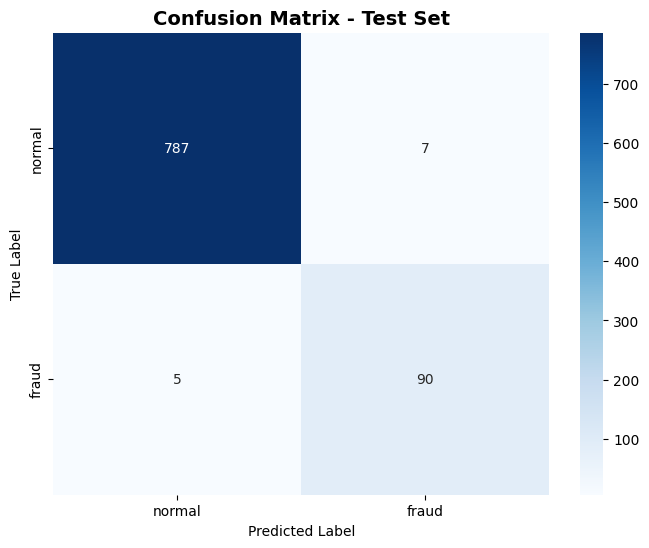


KEY METRICS FOR FRAUD DETECTION
True Negatives (correct normal): 787
False Positives (false alarms): 7
False Negatives (missed fraud): 5 ← MOST IMPORTANT
True Positives (caught fraud): 90

Fraud Detection Rate (Recall): 94.74%
Precision: 92.78%
F1-Score: 93.75%
Accuracy: 98.65%


In [ ]:
# Get predictions on test set
print("="*50)
print("TEST SET EVALUATION")
print("="*50)

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['normal', 'fraud']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal', 'fraud'],
            yticklabels=['normal', 'fraud'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate key metrics
tn, fp, fn, tp = cm.ravel()
print("\n" + "="*50)
print("KEY METRICS FOR FRAUD DETECTION")
print("="*50)
print(f"True Negatives (correct normal): {tn}")
print(f"False Positives (false alarms): {fp}")
print(f"False Negatives (missed fraud): {fn} ← MOST IMPORTANT")
print(f"True Positives (caught fraud): {tp}")
print(f"\nFraud Detection Rate (Recall): {tp/(tp+fn):.2%}")
print(f"Precision: {tp/(tp+fp):.2%}")
print(f"F1-Score: {2*tp/(2*tp+fp+fn):.2%}")
print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn):.2%}")


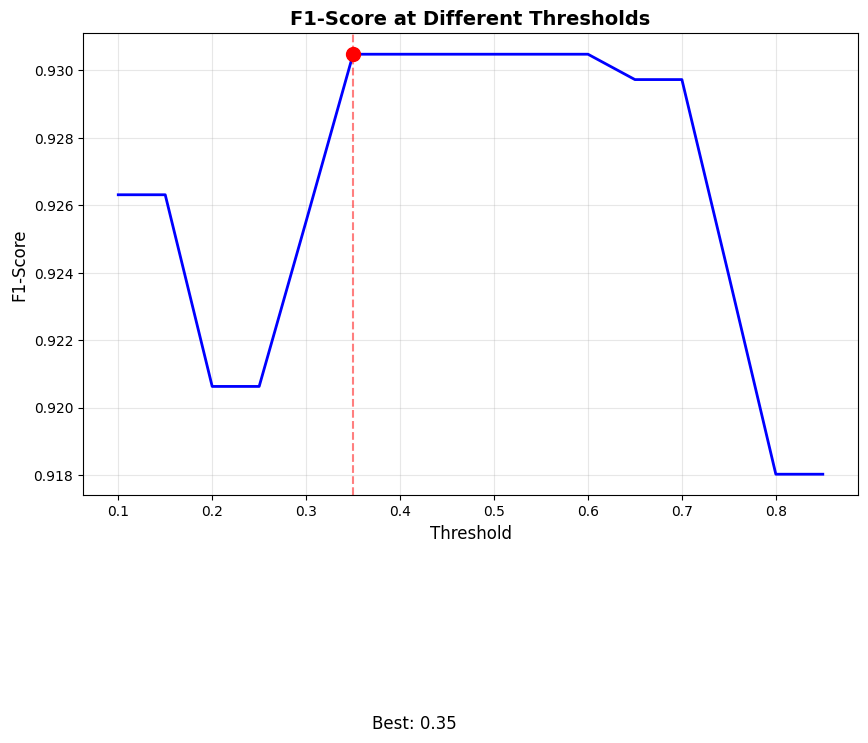

Optimal threshold: 0.35
Best F1-score at this threshold: 0.9305

Test set performance with optimal threshold:
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       794
       fraud       0.93      0.95      0.94        95

    accuracy                           0.99       889
   macro avg       0.96      0.97      0.96       889
weighted avg       0.99      0.99      0.99       889



In [ ]:
# Get probability predictions
import torch.nn.functional as F

# Function to get probabilities
def get_probabilities(model, dataset):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=32)
    probs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            prob = F.softmax(outputs.logits, dim=-1)
            probs.extend(prob[:, 1].cpu().numpy())  # Probability of fraud

    return np.array(probs)

# Get probabilities for validation set
val_probs = get_probabilities(model, val_dataset)
val_true = y_val.values

# Find optimal threshold
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    val_pred = (val_probs >= threshold).astype(int)
    f1 = f1_score(val_true, val_pred)
    f1_scores.append(f1)

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Plot threshold vs F1
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, 'b-', linewidth=2)
plt.scatter(best_threshold, best_f1, color='red', s=100, zorder=5)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('F1-Score at Different Thresholds', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.5)
plt.text(best_threshold+0.02, best_f1-0.02, f'Best: {best_threshold:.2f}', fontsize=12)
plt.show()

print(f"Optimal threshold: {best_threshold:.2f}")
print(f"Best F1-score at this threshold: {best_f1:.4f}")

# Evaluate test set with optimal threshold
test_probs = get_probabilities(model, test_dataset)
test_pred_optimal = (test_probs >= best_threshold).astype(int)
test_true = y_test.values

print("\nTest set performance with optimal threshold:")
print(classification_report(test_true, test_pred_optimal, target_names=['normal', 'fraud']))

In [ ]:
# Save model to Google Drive for persistence
import shutil
import os

# Create a folder in Drive
drive_model_path = '/content/drive/MyDrive/fraud_detection_model'
os.makedirs(drive_model_path, exist_ok=True)

# Copy model files
shutil.copytree('./best_fraud_model', drive_model_path, dirs_exist_ok=True)

print(f"Model saved to Google Drive: {drive_model_path}")
!ls -la "{drive_model_path}"

Model saved to Google Drive: /content/drive/MyDrive/fraud_detection_model
total 262258
-rw------- 1 root root       614 Feb 14 17:45 config.json
-rw------- 1 root root 267832560 Feb 14 17:45 model.safetensors
-rw------- 1 root root       328 Feb 14 17:45 tokenizer_config.json
-rw------- 1 root root    711396 Feb 14 17:45 tokenizer.json
-rw------- 1 root root      5201 Feb 14 17:45 training_args.bin


In [ ]:
# Download model to your local machine
from google.colab import files
import zipfile

# Zip the model
!zip -r fraud_model.zip ./best_fraud_model

# Download
files.download('fraud_model.zip')
print("Model downloaded as fraud_model.zip")

  adding: best_fraud_model/ (stored 0%)
  adding: best_fraud_model/training_args.bin (deflated 53%)
  adding: best_fraud_model/config.json (deflated 48%)
  adding: best_fraud_model/model.safetensors (deflated 8%)
  adding: best_fraud_model/tokenizer_config.json (deflated 42%)
  adding: best_fraud_model/tokenizer.json (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded as fraud_model.zip


In [ ]:
# Simple prediction function for deployment
def predict_fraud(text, model_path='./best_fraud_model', threshold=0.5):
    """
    Predict if a text message is fraud or normal

    Args:
        text: Input text string
        model_path: Path to saved model
        threshold: Probability threshold for fraud classification

    Returns:
        dict: Prediction results
    """
    # Load model and tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(model_path)
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # Clean text
    cleaned_text = clean_text(text)

    # Tokenize
    inputs = tokenizer(
        cleaned_text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    ).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = F.softmax(outputs.logits, dim=-1)
        fraud_prob = probabilities[0][1].item()
        normal_prob = probabilities[0][0].item()

    # Apply threshold
    prediction = 'fraud' if fraud_prob >= threshold else 'normal'
    confidence = fraud_prob if prediction == 'fraud' else normal_prob

    return {
        'text': text,
        'cleaned_text': cleaned_text,
        'prediction': prediction,
        'confidence': confidence,
        'fraud_probability': fraud_prob,
        'normal_probability': normal_prob,
        'threshold_used': threshold
    }

# Test the function
test_texts = [
    "hello, i m bank manager of SBI, ur debit card is about to expire would u want to issue new card",
    "Thank you for your message!",
    "Your account has been compromised, click here to verify",
    "Let's meet for coffee tomorrow"
]

print("="*50)
print("TEST PREDICTIONS")
print("="*50)
for text in test_texts:
    result = predict_fraud(text, threshold=best_threshold)
    print(f"\nText: {result['text']}")
    print(f"Prediction: {result['prediction'].upper()} (confidence: {result['confidence']:.2%})")
    print(f"Fraud probability: {result['fraud_probability']:.2%}")

TEST PREDICTIONS


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]


Text: hello, i m bank manager of SBI, ur debit card is about to expire would u want to issue new card
Prediction: FRAUD (confidence: 99.83%)
Fraud probability: 99.83%


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]


Text: Thank you for your message!
Prediction: NORMAL (confidence: 99.74%)
Fraud probability: 0.26%


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]


Text: Your account has been compromised, click here to verify
Prediction: FRAUD (confidence: 97.69%)
Fraud probability: 97.69%


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]


Text: Let's meet for coffee tomorrow
Prediction: NORMAL (confidence: 99.86%)
Fraud probability: 0.14%
